### Example benchmarking comparison between 2 Qiskit transpilers

In [7]:
from transpile_benchy.interface import QASMBench

qasm_bench = QASMBench(size="small")

from transpile_benchy.metrics import DepthMetric

depth_metric = DepthMetric()

from qiskit.transpiler import CouplingMap

coupling_map = CouplingMap.from_grid(4, 5)

In [8]:
from transpile_benchy.runner import CustomPassManager
from qiskit.transpiler.passes import (
    DenseLayout,
    LookaheadSwap,
    TrivialLayout,
    BasicSwap,
    SabreLayout,
    SabreSwap,
)
from qiskit.transpiler.passes import (
    ApplyLayout,
    SetLayout,
    FullAncillaAllocation,
    EnlargeWithAncilla,
)


class Trivial_Basic(CustomPassManager):
    def main_process(self):
        """Process the circuit."""
        self.pm.append(
            [
                TrivialLayout(self.coupling),
                FullAncillaAllocation(self.coupling),
                EnlargeWithAncilla(),
                ApplyLayout(),
                BasicSwap(self.coupling),
            ]
        )


# class Dense_Lookahead(CustomPassManager):
#     def main_process(self, circuit):
#         """Process the circuit."""
#         self.main_pm.append(
#             [
#                 DenseLayout(coupling_map),
#                 FullAncillaAllocation(coupling_map),
#                 EnlargeWithAncilla(),
#                 ApplyLayout(),
#                 LookaheadSwap(coupling_map),
#             ]
#         )
#         return self.main_pm.run(circuit)


class SABRE(CustomPassManager):
    def main_process(self):
        """Process the circuit."""
        self.pm.append(
            [
                SabreLayout(self.coupling),
                # FullAncillaAllocation(coupling_map),
                # EnlargeWithAncilla(),
                # ApplyLayout(),
                SabreSwap(self.coupling),
            ]
        )

In [9]:
import logging
from transpile_benchy.benchmark import Benchmark

# Create a specific logger for transpile_benchy and set its level to DEBUG
transpile_benchy_logger = logging.getLogger("transpile_benchy")
# transpile_benchy_logger.setLevel(logging.DEBUG)
transpile_benchy_logger.setLevel(logging.INFO)

# Silence the qiskit logger by setting its level to WARNING or higher
qiskit_logger = logging.getLogger("qiskit")
qiskit_logger.setLevel(logging.WARNING)

benchmark = Benchmark(
    [Trivial_Basic(coupling_map), SABRE(coupling_map)],
    [qasm_bench],
    [depth_metric],
    transpile_benchy_logger,
)
benchmark.run()

Running circuits for QASMBench: 100%|██████████| 38/38 [00:32<00:00,  1.18it/s]


here


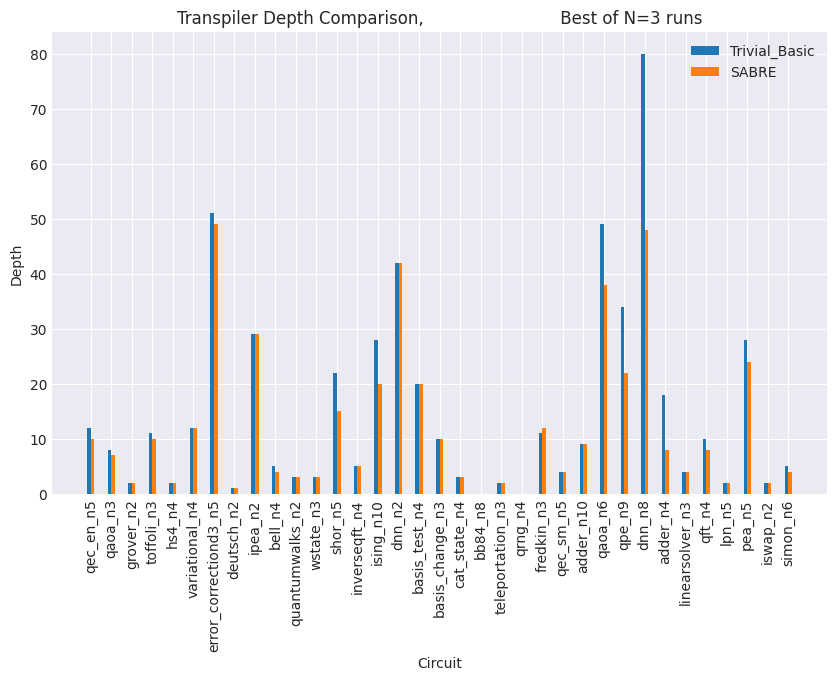

In [10]:
benchmark.plot(save=True)